<a href="https://colab.research.google.com/github/zw2788/LocalMinimaConstruction/blob/main/DwrtXGradientW_2weights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from typing import Tuple

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import copy

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from IPython.display import Image
from torch.autograd import grad


In [11]:
class SimpleNN(nn.Module):
    def __init__(self, custom_W_0, custom_b, custom_V_0, custom_c):
        super(SimpleNN, self).__init__()

        # Ensure that the custom weights are tensors
        custom_W_0 = torch.tensor(custom_W_0, dtype=torch.float64)
        custom_b = torch.tensor(custom_b, dtype=torch.float64)
        custom_V_0 = torch.tensor(custom_V_0, dtype=torch.float64)
        custom_c = torch.tensor(custom_c, dtype=torch.float64)

        # Set the custom weights and biases
        self.W_0 = nn.Parameter(custom_W_0)
        self.b = nn.Parameter(custom_b)
        self.V_0 = nn.Parameter(custom_V_0)
        self.c = nn.Parameter(custom_c)

    def forward(self, x):
        x = F.sigmoid(torch.add(torch.matmul(x, self.W_0), self.b))
        x = F.sigmoid(torch.add(torch.matmul(x, self.V_0), self.c))
        return x

# Example usage
#custom_W_0 = [[0.1, 0.2], [0.3, 0.4]]  # Replace with your own initial values
#custom_b = [0.1, 0.2]  # Replace with your own initial values
#custom_V_0 = [[0.1], [0.2]]  # Replace with your own initial values
#custom_c = [0.1]  # Replace with your own initial values


def calculate_second_order_grad(model, X_raw_torch, Y_torch):
    # Forward pass
    output = model(X_raw_torch)
    # Compute loss
    loss = -torch.mean(Y_torch * torch.log(output) + (1 - Y_torch) * torch.log(1 - output))
    # Compute gradients of the loss w.r.t. weights
    loss.backward(create_graph=True)
    # Combine and compute the norm of all gradients
    all_grads = torch.cat([param.grad.flatten() for param in model.parameters()])
    grad_norm = torch.norm(all_grads)
    #print(all_grads)
    # Compute the derivative of the grad_norm with respect to X
    second_order_grad = torch.autograd.grad(grad_norm, X_raw_torch, retain_graph=True)[0]
    return second_order_grad

def calculate_second_order_grad_trap(model, X_raw_torch, Y_torch):
    # Forward pass
    output = model(X_raw_torch)
    # Compute loss
    loss = -torch.mean(Y_torch * torch.log(output) + (1 - Y_torch) * torch.log(1 - output))
    # Compute gradients of the loss w.r.t. weights
    loss.backward(create_graph=True)
    # Combine and compute the norm of all gradients
    all_grads = torch.cat([param.grad.flatten() for param in model.parameters()])
    grad_norm = torch.norm(all_grads)
    #print(all_grads)
    # Compute the derivative of the grad_norm with respect to X
    second_order_grad = torch.autograd.grad(grad_norm, X_raw_torch, retain_graph=True)[0]
    return second_order_grad

def gradient_descent_on_input(model1, model2, X, Y, max_iterations, learning_rate=0.01):
    X_modifiable = X.clone().detach().requires_grad_(True)
    optimizer_x = optim.SGD([X_modifiable], lr=learning_rate)

    for i in range(max_iterations):
        optimizer_x.zero_grad()
        output1 = model1(X_modifiable)
        output2 = model2(X_modifiable)
        loss = -0.5*torch.mean(Y * torch.log(output1) + (1 - Y) * torch.log(1 - output1))-0.5*torch.mean(Y * torch.log(output2) + (1 - Y) * torch.log(1 - output2))
        loss.backward()
        optimizer_x.step()
        print(i)

    return X_modifiable


In [3]:
def perturb_weights_normal(model, max_deviation=0.01):
    with torch.no_grad():
        for param in model.parameters():
            std_dev = param.abs().mean() * max_deviation
            noise = torch.randn(param.size()) * std_dev
            param[:] = param + noise

def perturb_weights_uniform(model, max_deviation=0.01):
    with torch.no_grad():
        for param in model.parameters():
            scale_factor = param.abs().mean() * max_deviation
            # Generate uniform noise in the range [-scale_factor, scale_factor]
            noise = (torch.rand(param.size()) * 2 - 1) * scale_factor
            param[:] = param + noise
def perturb_weights_uniform_fixed_range(model, scale):
    with torch.no_grad():
        for param in model.parameters():
            # Generate uniform noise in the range [-0.1, 0.1]
            noise = (torch.rand(param.size()) * 2 - 1) * scale
            param[:] = param + noise

def restore_weights(model, saved_state):
    with torch.no_grad():
        for name, param in model.named_parameters():
            param[:] = saved_state[name]

def perturb_data(X, max_deviation=0.01):
    """Perturb the data tensor X."""
    with torch.no_grad():
        std_dev = X.abs().mean() * max_deviation
        noise = torch.randn(X.size()) * std_dev
        X.add_(noise)

In [4]:
# Re-executing the code to define the function for computing the Hessian matrix and its eigenvalues

def compute_hessian_and_eigenvalues(model, data, target):
    """
    Compute the Hessian matrix and its eigenvalues for the weights of a neural network model.

    :param model: The neural network model.
    :param data: Input data (X).
    :param target: Target data (Y).
    :return: Hessian matrix and its eigenvalues.
    """
    # Forward pass
    output = model(data)
    # Compute loss
    loss = -torch.mean(target * torch.log(output) + (1 - target) * torch.log(1 - output))

    # First-order gradients (w.r.t weights)
    first_order_grads = torch.autograd.grad(loss, model.parameters(), create_graph=True)

    # Flatten the first-order gradients
    grads_flatten = torch.cat([g.contiguous().view(-1) for g in first_order_grads])

    # Hessian computation
    hessian = []
    for grad in grads_flatten:
        # Compute second-order gradients (w.r.t each element in the first-order gradients)
        second_order_grads = torch.autograd.grad(grad, model.parameters(), retain_graph=True)

        # Flatten and collect the second-order gradients
        hessian_row = torch.cat([g.contiguous().view(-1) for g in second_order_grads])
        hessian.append(hessian_row)

    # Stack to form the Hessian matrix
    hessian_matrix = torch.stack(hessian)

    # Compute eigenvalues
    eigenvalues, _ = torch.linalg.eig(hessian_matrix)

    return hessian_matrix, eigenvalues

# Note: To use this function, you'll need to provide your neural network model, the input data (X), and the target data (Y).


def check_local_minimum(eigenvalues):
    # Check if all eigenvalues have a positive real part
    if all(eig.real > 0 for eig in eigenvalues):
        print("This is a local minimum.")
    else:
        print("This is not a local minimum.")


In [5]:
# Function to plot a single tensor
def plot_tensor(tensor_data, label='Data', marker='o', color='blue'):
    plt.figure(figsize=(6, 4))

    # Plotting the tensor
    plt.scatter(tensor_data[:, 0].detach().numpy(), tensor_data[:, 1].detach().numpy(), label=label, marker=marker, color=color)

    plt.xlabel('X Axis')
    plt.ylabel('Y Axis')
    plt.title(f'{label} Plot')
    plt.legend()
    plt.grid(True)
    plt.show()

In [6]:
data = pd.read_csv(
    "https://raw.githubusercontent.com/zw2788/LocalMinimaConstruction/main/8shape.csv")

data.head()

# data , drop NaN values
X_raw,  Y, W_0, b, V_0, c = data[['x_2dvec']].dropna().values, data['y'].dropna().values, data[['W_0']].dropna().values, data[['b']].dropna().values, data[['V_0']].dropna().values, data[['c']].dropna().values

#convert string to array

X_raw = np.array([eval(s[0]) for s in X_raw])

W_0 = np.array([eval(s[0]) for s in W_0])

b = np.array([eval(s[0]) for s in b])

V_0 = np.array([eval(s[0]) for s in V_0])

c = np.array([eval(s[0]) for s in c])

# Standardize the input
# Leave blank to match the example in paper

# formatting
Y = Y.reshape((-1, 1))
print(X_raw)
print(Y)
print(W_0)
#print(X_raw.shape[0])
X_raw = torch.tensor(X_raw, requires_grad=True)
Y = torch.tensor(Y)
print(W_0, b, V_0, c)

[[-4.  -4. ]
 [-4.  -1. ]
 [-1.  -1. ]
 [-1.   2. ]
 [ 2.   2. ]
 [-3.  -4. ]
 [-1.5 -4. ]
 [-1.5 -0.5]
 [ 1.  -1. ]
 [ 1.5  2.5]]
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[-7.60825117  3.76327948]
 [-4.83862577  6.00303144]]
[[-7.60825117  3.76327948]
 [-4.83862577  6.00303144]] [[-14.73302609   7.71711836]] [[8.94303407]
 [6.73296582]] [[-6.73776928]]


In [8]:
data2 = pd.read_csv(
    "https://raw.githubusercontent.com/zw2788/LocalMinimaConstruction/main/8shape2.csv")

data2.head()

# data , drop NaN values
X_raw2,  Y2, W_02, b2, V_02, c2 = data2[['x_2dvec']].dropna().values, data2['y'].dropna().values, data2[['W_0']].dropna().values, data2[['b']].dropna().values, data2[['V_0']].dropna().values, data2[['c']].dropna().values

#convert string to array

X_raw2 = np.array([eval(s[0]) for s in X_raw2])

W_02 = np.array([eval(s[0]) for s in W_02])

b2 = np.array([eval(s[0]) for s in b2])

V_02 = np.array([eval(s[0]) for s in V_02])

c2 = np.array([eval(s[0]) for s in c2])

# Standardize the input
# Leave blank to match the example in paper

# formatting
Y2 = Y2.reshape((-1, 1))
print(X_raw2)
print(Y2)
print(W_02)
#print(X_raw.shape[0])
X_raw2 = torch.tensor(X_raw2, requires_grad=True)
Y2 = torch.tensor(Y2)
print(W_02, b2, V_02, c2)

[[-4.  -4. ]
 [-4.  -1. ]
 [-1.  -1. ]
 [-1.   2. ]
 [ 2.   2. ]
 [-3.  -4. ]
 [-1.5 -4. ]
 [-1.5 -0.5]
 [ 1.  -1. ]
 [ 1.5  2.5]]
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[-7.66574487  3.76099758]
 [-0.90854956 -4.37151541]]
[[-7.66574487  3.76099758]
 [-0.90854956 -4.37151541]] [[-14.75920603   2.49352328]] [[10.41674876]
 [-1.40030991]] [[0.002344]]


In [9]:
nn_model = SimpleNN(W_0, b, V_0, c)
hessian_matrix_initial, eigenvalues_initial = compute_hessian_and_eigenvalues(nn_model, X_raw, Y)

print(eigenvalues_initial)
check_local_minimum(eigenvalues_initial)

tensor([ 2.3788e-01+0.j, -1.4928e-01+0.j, -6.5649e-02+0.j,  7.3909e-02+0.j,
         4.5694e-02+0.j,  2.4847e-03+0.j, -1.4595e-03+0.j, -2.0535e-07+0.j,
         1.2317e-03+0.j], dtype=torch.complex128)
This is not a local minimum.


In [10]:
nn_model2 = SimpleNN(W_02, b2, V_02, c2)
hessian_matrix_initial2, eigenvalues_initial2 = compute_hessian_and_eigenvalues(nn_model2, X_raw2, Y2)

print(eigenvalues_initial2)
check_local_minimum(eigenvalues_initial2)

tensor([-7.6122e-01+0.j,  1.6606e-01+0.j, -1.3180e-01+0.j,  7.4267e-02+0.j,
         2.8923e-02+0.j, -2.1644e-02+0.j,  1.4523e-02+0.j, -1.4199e-04+0.j,
        -3.5624e-03+0.j], dtype=torch.complex128)
This is not a local minimum.


In [113]:
nn_model_GD1 = SimpleNN(W_0, b, V_0, c)
nn_model_GD2 = SimpleNN(W_02, b2, V_02, c2)
X_GD = gradient_descent_on_input(nn_model_GD1, nn_model_GD2, X_raw, Y, max_iterations=50000, learning_rate=0.01)
print("X_raw is {}".format(X_raw))
print("X_GD is {}".format(X_GD))

hessian_matrix_GD1, eigenvalues_GD1 = compute_hessian_and_eigenvalues(nn_model_GD1, X_GD, Y)
hessian_matrix_GD2, eigenvalues_GD2 = compute_hessian_and_eigenvalues(nn_model_GD2, X_GD, Y)

print(eigenvalues_GD1)
check_local_minimum(eigenvalues_GD1)
print(eigenvalues_GD2)
check_local_minimum(eigenvalues_GD2)

流式输出内容被截断，只能显示最后 5000 行内容。
45028
45029
45030
45031
45032
45033
45034
45035
45036
45037
45038
45039
45040
45041
45042
45043
45044
45045
45046
45047
45048
45049
45050
45051
45052
45053
45054
45055
45056
45057
45058
45059
45060
45061
45062
45063
45064
45065
45066
45067
45068
45069
45070
45071
45072
45073
45074
45075
45076
45077
45078
45079
45080
45081
45082
45083
45084
45085
45086
45087
45088
45089
45090
45091
45092
45093
45094
45095
45096
45097
45098
45099
45100
45101
45102
45103
45104
45105
45106
45107
45108
45109
45110
45111
45112
45113
45114
45115
45116
45117
45118
45119
45120
45121
45122
45123
45124
45125
45126
45127
45128
45129
45130
45131
45132
45133
45134
45135
45136
45137
45138
45139
45140
45141
45142
45143
45144
45145
45146
45147
45148
45149
45150
45151
45152
45153
45154
45155
45156
45157
45158
45159
45160
45161
45162
45163
45164
45165
45166
45167
45168
45169
45170
45171
45172
45173
45174
45175
45176
45177
45178
45179
45180
45181
45182
45183
45184
45185
45186
45187
45188
45189
4

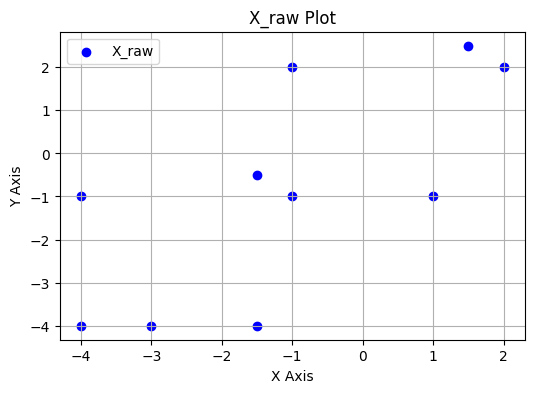

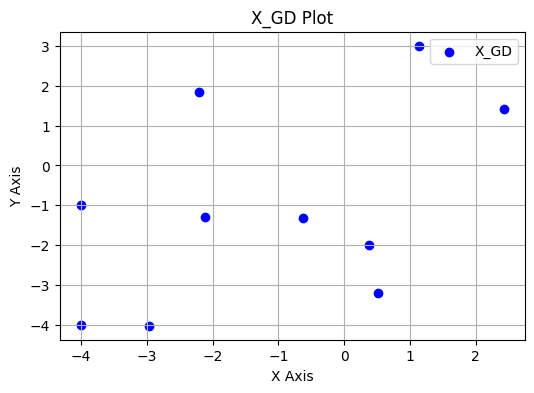

In [114]:
plot_tensor(X_raw, label='X_raw', marker='o', color='blue')
plot_tensor(X_GD, label='X_GD', marker='o', color='blue')

In [153]:
def optimize_data_with_centralgradients(X_raw, Y, model1, model2, max_iterations=20, learning_rate=0.1,  threshold=0.001):
    """
    Optimize data using gradient calculations and Monte Carlo method.

    :param nn_model: Neural Network Model class.
    :param X_raw: Input data.
    :param Y: Target data.
    :param W_0, b, V_0, c: Initial weights and biases for the neural network.
    :param max_iterations: Maximum number of iterations.
    :param learning_rate: Learning rate for optimization.
    :param MC_num_samples: Number of samples for Monte Carlo method.
    :param surrounding_proportion: Proportion of surrounding points' gradients.
    :param max_deviation_for_weight: Maximum deviation for weight perturbation.
    :param threshold: Threshold for the norm of the second-order gradient.
    :return: Optimized X_raw tensor.
    """

    # Convert data to PyTorch tensors
    X_raw_tensor = X_raw.clone().detach().requires_grad_(True) if X_raw.requires_grad else torch.tensor(X_raw, dtype=torch.float64, requires_grad=True)
    Y_tensor = Y.clone().detach().requires_grad_(True) if Y.requires_grad else torch.tensor(Y, dtype=torch.float64, requires_grad=True)


    # Initialize the neural network with provided weights
    #nn_model_instance1 = SimpleNN(W_0, b, V_0, c)
    nn_model_instance1 = model1
    nn_model_instance2 = model2

    # Store original weights
    original_weights1 = {
        'W_0': nn_model_instance1.W_0.data.clone(),
        'b': nn_model_instance1.b.data.clone(),
        'V_0': nn_model_instance1.V_0.data.clone(),
        'c': nn_model_instance1.c.data.clone()
    }
    original_weights2 = {
        'W_0': nn_model_instance2.W_0.data.clone(),
        'b': nn_model_instance2.b.data.clone(),
        'V_0': nn_model_instance2.V_0.data.clone(),
        'c': nn_model_instance2.c.data.clone()
    }
    print("Original weight1 is {}".format(original_weights1))
    print("Original weight2 is {}".format(original_weights2))
    print("Initial X_GD {}".format(X_raw_tensor))

    for i in range(max_iterations):
        # [Insert the existing logic of your loop here, using nn_model_instance, X_raw_tensor, Y_tensor, and other parameters]
        # Calculate the gradient at the central point
        central_grad1 = calculate_second_order_grad(nn_model_instance1, X_raw_tensor, Y_tensor)
        central_grad2 = calculate_second_order_grad(nn_model_instance2, X_raw_tensor, Y_tensor)
        # Check if grad_X is None before proceeding
        central_grad_norm1 = torch.norm(central_grad1)
        central_grad1 = central_grad1 / central_grad_norm1
        central_grad_norm2 = torch.norm(central_grad2)
        central_grad2 = central_grad2 / central_grad_norm2
        #print(central_grad)
        # Surrouning points' grads
        #surrounding_grads_pre = []
        #norms_pre = []
        #negative_eigenvalues = []


        # Combine gradients
        combined_grad = (central_grad1 + central_grad2)/2
        #combined_grad =  average_surrounding_grad
        #print(combined_grad)
        # Calculate the norm of the combined gradient
        combined_grad_norm = torch.norm(combined_grad)

        # Check for a non-zero norm to avoid division by zero
        if combined_grad_norm == 0:
        # Normalize the gradient
          print("Gradient is zero; no update required.")

###############

        # Check if the norm of the second-order gradient is below the threshold
        if torch.norm(combined_grad) < threshold:
            print(f"Convergence reached at iteration {i}")
            break
        # Update X_raw using the normalized gradient and learning rate
        X_raw_tensor.data -= learning_rate * combined_grad_norm

        # Zero out gradients for the next iteration
        nn_model_instance1.zero_grad()
        nn_model_instance2.zero_grad()
        X_raw_tensor.grad = None
        # Update and checks as per your original code



    # Print final modified data

    print("Output X is: {}".format(X_raw_tensor))


    print(central_grad_norm1)
    print(central_grad_norm2)
    # Return the optimized X_raw tensor
    return X_raw_tensor

# Example usage
nn_model_F1 = SimpleNN(W_0, b, V_0, c)
nn_model_F2 = SimpleNN(W_02, b2, V_02, c2)
optimized_X_1 = optimize_data_with_centralgradients(X_GD, Y, nn_model_F1, nn_model_F2, max_iterations=826, learning_rate=0.001,  threshold=0.0001)


<ipython-input-153-ffe13a9271a5>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_tensor = Y.clone().detach().requires_grad_(True) if Y.requires_grad else torch.tensor(Y, dtype=torch.float64, requires_grad=True)


Original weight1 is {'W_0': tensor([[-7.6083,  3.7633],
        [-4.8386,  6.0030]], dtype=torch.float64), 'b': tensor([[-14.7330,   7.7171]], dtype=torch.float64), 'V_0': tensor([[8.9430],
        [6.7330]], dtype=torch.float64), 'c': tensor([[-6.7378]], dtype=torch.float64)}
Original weight2 is {'W_0': tensor([[-7.6657,  3.7610],
        [-0.9085, -4.3715]], dtype=torch.float64), 'b': tensor([[-14.7592,   2.4935]], dtype=torch.float64), 'V_0': tensor([[10.4167],
        [-1.4003]], dtype=torch.float64), 'c': tensor([[0.0023]], dtype=torch.float64)}
Initial X_GD tensor([[-4.0001, -3.9999],
        [-3.9999, -0.9998],
        [-2.1119, -1.2889],
        [-2.2003,  1.8486],
        [ 1.1386,  3.0013],
        [-2.9645, -4.0210],
        [ 0.5143, -3.2021],
        [-0.6192, -1.3305],
        [ 0.3772, -1.9945],
        [ 2.4241,  1.4258]], dtype=torch.float64, requires_grad=True)
Output X is: tensor([[-4.5267, -4.5264],
        [-4.5264, -1.5264],
        [-2.6384, -1.8154],
        [-2

In [154]:
nn_model1 = SimpleNN(W_0, b, V_0, c)
hessian_matrix_central1, eigenvalues_central1 = compute_hessian_and_eigenvalues(nn_model1, optimized_X_1, Y)

print(eigenvalues_central1)
check_local_minimum(eigenvalues_central1)


nn_model2 = SimpleNN(W_02, b2, V_02, c2)
hessian_matrix_central2, eigenvalues_central2 = compute_hessian_and_eigenvalues(nn_model2, optimized_X_1, Y)

print(eigenvalues_central2)
check_local_minimum(eigenvalues_central2)

tensor([-4.5436e-01+0.j,  1.7779e-01+0.j,  7.6419e-02+0.j,  5.1844e-02+0.j,
         1.5234e-03+0.j,  7.4462e-04+0.j,  3.9259e-04+0.j, -2.8857e-05+0.j,
         7.2256e-08+0.j], dtype=torch.complex128)
This is not a local minimum.
tensor([ 1.4415e-01+0.j,  1.8839e-02+0.j,  1.1159e-02+0.j,  2.0681e-03+0.j,
        -1.0963e-07+0.j,  1.6380e-05+0.j,  7.9199e-06+0.j,  2.5782e-04+0.j,
         2.1626e-04+0.j], dtype=torch.complex128)
This is not a local minimum.


流式输出内容被截断，只能显示最后 5000 行内容。
        [ 1.5000,  2.5000]], dtype=torch.float64, requires_grad=True)
tensor(0.0010, dtype=torch.float64, grad_fn=<SubBackward0>)
before tensor([[-4.0000, -4.0000],
        [-4.0000, -1.0000],
        [ 0.4444, -2.4870],
        [-1.0000,  2.0000],
        [ 2.0000,  2.0000],
        [-3.0000, -4.0000],
        [-1.5000, -4.0000],
        [-4.0682,  2.1464],
        [ 1.1326, -0.7886],
        [ 1.5000,  2.5000]], dtype=torch.float64, requires_grad=True)
tensor(0.0010, dtype=torch.float64, grad_fn=<SubBackward0>)
before tensor([[-4.0000, -4.0000],
        [-4.0000, -1.0000],
        [ 0.4446, -2.4873],
        [-1.0000,  2.0000],
        [ 2.0000,  2.0000],
        [-3.0000, -4.0000],
        [-1.5000, -4.0000],
        [-4.0686,  2.1468],
        [ 1.1326, -0.7885],
        [ 1.5000,  2.5000]], dtype=torch.float64, requires_grad=True)
tensor(0.0010, dtype=torch.float64, grad_fn=<SubBackward0>)
before tensor([[-4.0000, -4.0000],
        [-4.0000, -1.0000],
  

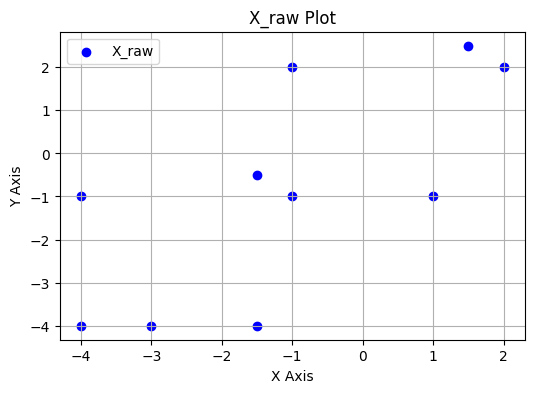

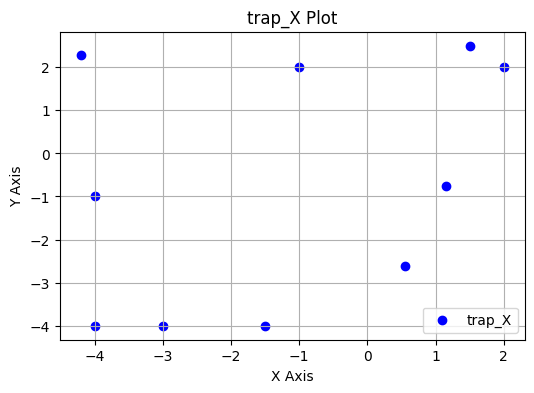

In [ ]:
# Enable anomaly detection
torch.autograd.set_detect_anomaly(True)

def make_model_copy(original_model):
    # Create a new instance of the model
    model_copy = SimpleNN(W_0, b, V_0, c)  # Use the same parameters as used to create the original model
    # Copy the initial weights from the original model
    model_copy.load_state_dict(original_model.state_dict())
    return model_copy

def trap_model(original_model, X, Y, max_iterations, number_of_x_iterations, weightlr=0.01, xlr=0.01):
    X_modifiable = X.clone().detach().requires_grad_(True)

    for current_iteration in range(max_iterations):
        # Use a fresh copy of the model
        model = make_model_copy(original_model)

        optimizer_weights = optim.SGD(model.parameters(), lr=weightlr)

    # Optimizer for the weights
    #optimizer_weights = optim.SGD(model.parameters(), lr=weightlr)

        # Save initial state of the model
        initial_state_dict = model.state_dict()

        # Load initial weights using the deep copied state
        model.load_state_dict(copy.deepcopy(initial_state_dict))

        # Reset the optimizer state
        optimizer_weights = optim.SGD(model.parameters(), lr=weightlr)

        # Forward pass with current X_modifiable and initial weights
        model_output = model(X_modifiable)

        old_loss = -torch.mean(Y * torch.log(model_output) + (1 - Y) * torch.log(1 - model_output))

        # Gradient descent step for weights
        optimizer_weights.zero_grad()
        old_loss.backward()
        optimizer_weights.step()
        # Gather all gradients into a list after flattening
        gradients = [param.grad.view(-1) for param in model.parameters() if param.grad is not None]

        # Concatenate all gradients to form a single vector and calculate its norm
        total_gradient = torch.cat(gradients)
        total_gradient_norm = total_gradient.norm()

        # Check if the combined gradient norm is below the threshold
        if total_gradient_norm < 1e-8:
            print("Combined gradient norm below threshold, stopping optimization.")
            break

        # Save new weights and create a copy of X_modifiable for the inner loop
        new_state_dict = model.state_dict()
        X_inner = X_modifiable.clone().detach().requires_grad_(True)
        optimizer_x = optim.SGD([X_inner], lr=xlr)

        for _ in range(number_of_x_iterations):
            # Load new weights
            model.load_state_dict(new_state_dict)
            print("before {}".format(X_inner))
            output_new = model(X_inner)
            new_loss = -torch.mean(Y * torch.log(output_new) + (1 - Y) * torch.log(1 - output_new))

            # Calculate combined loss
            combined_loss = old_loss.detach() - new_loss
            print(combined_loss)


            # Check condition
            if combined_loss <= 0:
                print("acheive! at:{}".format(current_iteration))
                print(X_inner)
                break
            else:
                optimizer_x.zero_grad()
                combined_loss.backward()
                optimizer_x.step()
        #print(X_inner.data)
        # Update X_modifiable with changes from the inner loop
        # Calculate the difference between X_modifiable and X_inner
        difference = (X_modifiable - X_inner).norm()

        # Check if the difference is below a certain threshold
        if difference < 1e-8:  # You can adjust this threshold as needed
          print("X_modifiable did not change significantly, stopping early.")
          break
        else:

          # Update X_modifiable with changes from the inner loop
          X_modifiable.data = X_inner.data


    # After completing all iterations, load initial weights
    model.load_state_dict(initial_state_dict)

    # Forward pass with the final X_modifiable and initial weights
    final_output = model(X_modifiable)
    final_loss = -torch.mean(Y * torch.log(final_output) + (1 - Y) * torch.log(1 - final_output))

    # Calculate gradients with respect to the initial weights
    optimizer_weights.zero_grad()
    final_loss.backward()

    # Calculate and print the norm of the gradients for each parameter
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"Gradient norm for {name}: {param.grad.norm().item()}")

    # Return the modified X
    return X_modifiable

# Initialize your model, X, Y, etc. outside the function
# ... [Your initialization code here] ...

# Call the function
# ... [Call to train_model function here] ...
#Example
# Initialize your model, X, Y, etc. outside the function
#custom_W_0 = [...]  # Replace [...] with your initial weights
#custom_b = [...]   # Replace [...] with your initial bias
#custom_V_0 = [...]  # Replace [...] with your next layer weights
#custom_c = [...]   # Replace [...] with your next layer bias
#model = SimpleNN(custom_W_0, custom_b, custom_V_0, custom_c)
#X = torch.tensor([...], dtype=torch.float64, requires_grad=True)  # Replace [...] with your initial data
#Y = torch.tensor([...], dtype=torch.float64)  # Replace [...] with target data

# Call the function
nn_model_trap = SimpleNN(W_0, b, V_0, c)
trap_X = trap_model(nn_model_trap, X_raw, Y, max_iterations=1000, number_of_x_iterations=2, weightlr= 0.01, xlr= 0.05)
plot_tensor(X_raw, label='X_raw', marker='o', color='blue')
plot_tensor(trap_X, label='trap_X', marker='o', color='blue')

In [ ]:
print(X_raw)
print(trap_X)
hessian_matrix_trap, eigenvalues_trap = compute_hessian_and_eigenvalues(nn_model_trap, trap_X, Y)

print(eigenvalues_trap)
check_local_minimum(eigenvalues_trap)

tensor([[-4.0000, -4.0000],
        [-4.0000, -1.0000],
        [-1.0000, -1.0000],
        [-1.0000,  2.0000],
        [ 2.0000,  2.0000],
        [-3.0000, -4.0000],
        [-1.5000, -4.0000],
        [-1.5000, -0.5000],
        [ 1.0000, -1.0000],
        [ 1.5000,  2.5000]], dtype=torch.float64, requires_grad=True)
tensor([[-4.0000, -4.0000],
        [-4.0000, -1.0001],
        [ 0.5549, -2.6030],
        [-1.0000,  2.0000],
        [ 2.0000,  2.0000],
        [-3.0000, -4.0000],
        [-1.5001, -4.0000],
        [-4.2049,  2.2899],
        [ 1.1506, -0.7598],
        [ 1.5000,  2.5000]], dtype=torch.float64, requires_grad=True)
tensor([ 2.2362e-01+0.j,  4.8039e-02+0.j, -4.8185e-02+0.j, -6.2189e-02+0.j,
        -8.2112e-03+0.j, -1.0625e-02+0.j, -2.0603e-07+0.j,  9.2078e-05+0.j,
        -1.8258e-04+0.j], dtype=torch.complex128)
This is not a local minimum.


In [ ]:
def optimize_data_with_gradients(X_raw, Y, W_0, b, V_0, c, max_iterations=20, learning_rate=0.1, MC_num_samples=100, surrounding_proportion=0.5, max_deviation_for_weight=0.05, threshold=0.001):
    """
    Optimize data using gradient calculations and Monte Carlo method.

    :param nn_model: Neural Network Model class.
    :param X_raw: Input data.
    :param Y: Target data.
    :param W_0, b, V_0, c: Initial weights and biases for the neural network.
    :param max_iterations: Maximum number of iterations.
    :param learning_rate: Learning rate for optimization.
    :param MC_num_samples: Number of samples for Monte Carlo method.
    :param surrounding_proportion: Proportion of surrounding points' gradients.
    :param max_deviation_for_weight: Maximum deviation for weight perturbation.
    :param threshold: Threshold for the norm of the second-order gradient.
    :return: Optimized X_raw tensor.
    """

    # Convert data to PyTorch tensors
    X_raw_tensor = X_raw.clone().detach().requires_grad_(True) if X_raw.requires_grad else torch.tensor(X_raw, dtype=torch.float64, requires_grad=True)
    Y_tensor = Y.clone().detach().requires_grad_(True) if Y.requires_grad else torch.tensor(Y, dtype=torch.float64, requires_grad=True)


    # Initialize the neural network with provided weights
    nn_model_sur = SimpleNN(W_0, b, V_0, c)

    # Store original weights
    original_weights = {
        'W_0': nn_model_sur.W_0.data.clone(),
        'b': nn_model_sur.b.data.clone(),
        'V_0': nn_model_sur.V_0.data.clone(),
        'c': nn_model_sur.c.data.clone()
    }
    print("Original weight is {}".format(original_weights))
    print("Initial X_raw_pre {}".format(X_raw_tensor))

    for i in range(max_iterations):
        # [Insert the existing logic of your loop here, using nn_model_instance, X_raw_tensor, Y_tensor, and other parameters]
        # Calculate the gradient at the central point
        central_grad = calculate_second_order_grad(nn_model_sur, X_raw_tensor, Y_tensor)
        # Check if grad_X is None before proceeding
        central_grad_norm = torch.norm(central_grad)
        central_grad = central_grad / central_grad_norm
        #print(central_grad)
        # Surrouning points' grads
        surrounding_grads_pre = []
        norms_pre = []


        # Calculate the gradient at the surrounding points by MC
        for _ in range(MC_num_samples):

            nn_model_sample_pre = SimpleNN(custom_W_0=original_weights['W_0'],custom_b=original_weights['b'],custom_V_0=original_weights['V_0'],custom_c=original_weights['c'])
            #print("W_0 (before perturbation):", nn_model_sample.W_0.data)
            # Perturb weights
            #perturb_weights_uniform_fixed_range(nn_model_sample, max_deviation=max_deviation_for_weight)
            perturb_weights_uniform_fixed_range(nn_model_sample_pre, scale = max_deviation_for_weight)
            #print("W_0 (after perturbation):", nn_model_sample.W_0.data)
            grad_pre = calculate_second_order_grad(nn_model_sample_pre, X_raw_tensor, Y_tensor)
            grad_norm = torch.norm(grad_pre)
            grad_pre = grad_pre / grad_norm
            surrounding_grads_pre.append(grad_pre)
            #negative_eigenvalues.append(torch.norm(grad_pre).item())

        sum_surrounding_grads_pre = sum(surrounding_grads_pre)

        # Average the large norm gradients
        average_surrounding_grads_pre = sum_surrounding_grads_pre / len(surrounding_grads_pre)
        # Calculate average pre_norm
        #average_negative_eigenvalues = sum(negative_eigenvalues) / len(negative_eigenvalues)

        # Calculate the median of negative eigenvalues
        #median_negative_eigenvalue = np.median([eigenvalue for eigenvalue in negative_eigenvalues if eigenvalue < 0])


        # Filter gradients corresponding to the smallest 50% of negative eigenvalues
        #above_average_negative_eigenvalues = [grad for grad, eigenvalue in zip(surrounding_grads_pre, negative_eigenvalues) if eigenvalue < median_negative_eigenvalue]
        #above_average_negative_eigenvalues = [grad / torch.norm(grad) for grad in above_average_negative_eigenvalues]

        #print(above_average_grads)
        #sum_above_average_negative_eigenvalues = sum(above_average_negative_eigenvalues)

        # Average the large norm gradients
        #if above_average_negative_eigenvalues:
          #average_above_average_negative_eigenvalues = sum_above_average_negative_eigenvalues / len(above_average_negative_eigenvalues)
          #print(average_above_average_grad)
        #else:
          # Handle the case where no gradient is above average
          #average_above_average_negative_eigenvalues = torch.zeros_like(X_raw_tensor)


        #print("Surrounding grad {}".format(surrounding_grads))

        # Combine gradients
        combined_grad = (1-surrounding_proportion) * central_grad + surrounding_proportion * average_surrounding_grads_pre
        #combined_grad =  average_surrounding_grad
        #print(combined_grad)
        # Calculate the norm of the combined gradient
        combined_grad_norm = torch.norm(combined_grad)

        # Check for a non-zero norm to avoid division by zero
        if combined_grad_norm > 0:
        # Normalize the gradient
          normalized_grad = combined_grad / combined_grad_norm

        else:
          print("Gradient is zero; no update required.")
###############

        # Check if the norm of the second-order gradient is below the threshold
        if torch.norm(combined_grad) < threshold:
            print(f"Convergence reached at iteration {i}")
            break
        # Update X_raw using the normalized gradient and learning rate
        X_raw_tensor.data -= learning_rate * normalized_grad

        # Zero out gradients for the next iteration
        nn_model_sur.zero_grad()
        X_raw_tensor.grad = None
        # Update and checks as per your original code



    # Print final modified data
    #print(surrounding_grads)
    #print("Final modified X_raw:")
    #if len(above_average_negative_eigenvalues) < 0.5*MC_pre_num_samples:
      #print("need more MC_pre_num_samples")
    #else:
    #print("Used surrounding points: {}".format(len(above_average_negative_eigenvalues)))

    print("Output X is: {}".format(X_raw_tensor))
    #print(negative_eigenvalues)



    # Return the optimized X_raw tensor
    return X_raw_tensor

# Example usage
optimized_X_2 = optimize_data_with_gradients(trap_X, Y, W_0, b, V_0, c, max_iterations=50, learning_rate=0.1, MC_num_samples=100, surrounding_proportion=0.3, max_deviation_for_weight=0.01, threshold=0.001)


<ipython-input-29-5816f8b1477c>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_tensor = Y.clone().detach().requires_grad_(True) if Y.requires_grad else torch.tensor(Y, dtype=torch.float64, requires_grad=True)
<ipython-input-3-2e4822dd5dc3>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  custom_W_0 = torch.tensor(custom_W_0, dtype=torch.float64)
<ipython-input-3-2e4822dd5dc3>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  custom_b = torch.tensor(custom_b, dtype=torch.float64)
<ipython-input-3-2e4822dd5dc3>:8: UserWarning: To copy c

Original weight is {'W_0': tensor([[-0.9854, -7.0746],
        [-0.7950, -5.9667]], dtype=torch.float64), 'b': tensor([[2.9537, 2.3977]], dtype=torch.float64), 'V_0': tensor([[-8.6610],
        [-6.9776]], dtype=torch.float64), 'c': tensor([[6.6996]], dtype=torch.float64)}
Initial X_raw_pre tensor([[ 0.1222,  0.1974],
        [ 0.6699,  1.4908],
        [ 0.1828,  0.1296],
        [-3.1624, -3.5892],
        [ 0.2212,  0.0867],
        [ 0.2715, -0.6380],
        [ 0.7825,  1.3818],
        [ 1.3966,  3.5302],
        [ 0.2329,  0.0736],
        [ 2.6141, -0.3701]], dtype=torch.float64, requires_grad=True)
Output X is: tensor([[-0.1250, -0.0626],
        [ 0.2896,  1.2047],
        [-0.0676, -0.1333],
        [-3.1624, -3.5891],
        [-0.0313, -0.1780],
        [ 0.2775, -0.6330],
        [ 0.3866,  1.0816],
        [ 4.3140,  5.7800],
        [-0.0203, -0.1916],
        [ 1.9599, -0.9091]], dtype=torch.float64, requires_grad=True)


In [ ]:
nn_model_X2 = SimpleNN(W_0, b, V_0, c)
hessian_matrix_surrounding, eigenvalues_surrounding = compute_hessian_and_eigenvalues(nn_model_X2, optimized_X_2, Y)

print(eigenvalues_surrounding)
check_local_minimum(eigenvalues_surrounding)

tensor([ 0.3254+0.j,  0.2093+0.j, -0.1277+0.j, -0.0679+0.j,  0.0189+0.j,  0.0015+0.j,
        -0.0028+0.j, -0.0007+0.j, -0.0010+0.j], dtype=torch.complex128)
This is not a local minimum.


In [ ]:
optimized_X_2 = optimize_data_with_gradients(optimized_X_1, Y, W_0, b, V_0, c, max_iterations=20, learning_rate=0.05, MC_num_samples=100, surrounding_proportion=0.9, max_deviation_for_weight=0.02, threshold=0.001)

<ipython-input-19-1e9be29dee3d>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_raw_tensor = torch.tensor(X_raw, requires_grad=True)
<ipython-input-19-1e9be29dee3d>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_tensor = torch.tensor(Y)
<ipython-input-3-a815e9696fa5>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  custom_W_0 = torch.tensor(custom_W_0, dtype=torch.float64)
<ipython-input-3-a815e9696fa5>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().

Original weight is {'W_0': tensor([[ 3.9979,  5.2638],
        [ 1.0698, -1.8901]], dtype=torch.float64), 'b': tensor([[1.8545, 0.8022]], dtype=torch.float64), 'V_0': tensor([[-10.1389],
        [-10.4242]], dtype=torch.float64), 'c': tensor([[5.0116]], dtype=torch.float64)}
Initial X_raw_pre tensor([[11.0898, -7.6508],
        [ 1.6931, -6.0680],
        [ 4.9975, -0.8779],
        [ 6.1208, -5.1308],
        [-5.5432, -6.2103],
        [ 1.1082,  0.1752],
        [-7.4783,  0.5124],
        [-7.9947,  0.8285],
        [-1.3351,  2.2657],
        [-3.4568,  2.3168]], dtype=torch.float64, requires_grad=True)
Used surrounding points: 50
Output X is: tensor([[11.0898, -7.6508],
        [ 1.6931, -6.0680],
        [ 4.9975, -0.8779],
        [ 6.1208, -5.1308],
        [-5.5432, -6.2103],
        [ 1.1082,  0.1752],
        [-7.4783,  0.5124],
        [-7.9947,  0.8285],
        [-1.3568,  2.0730],
        [-3.4338,  2.3244]], dtype=torch.float64, requires_grad=True)
[tensor(-0.0003, dtyp

In [ ]:
optimized_X_3 = optimize_data_with_gradients(optimized_X_2, Y, W_0, b, V_0, c, max_iterations=20, learning_rate=0.02, MC_num_samples=100, surrounding_proportion=0.9, max_deviation_for_weight=0.01, threshold=0.001)

<ipython-input-19-1e9be29dee3d>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_raw_tensor = torch.tensor(X_raw, requires_grad=True)
<ipython-input-19-1e9be29dee3d>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_tensor = torch.tensor(Y)
<ipython-input-3-a815e9696fa5>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  custom_W_0 = torch.tensor(custom_W_0, dtype=torch.float64)
<ipython-input-3-a815e9696fa5>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().

Original weight is {'W_0': tensor([[ 3.9979,  5.2638],
        [ 1.0698, -1.8901]], dtype=torch.float64), 'b': tensor([[1.8545, 0.8022]], dtype=torch.float64), 'V_0': tensor([[-10.1389],
        [-10.4242]], dtype=torch.float64), 'c': tensor([[5.0116]], dtype=torch.float64)}
Initial X_raw_pre tensor([[11.0898, -7.6508],
        [ 1.6931, -6.0680],
        [ 4.9975, -0.8779],
        [ 6.1208, -5.1308],
        [-5.5432, -6.2103],
        [ 1.1082,  0.1752],
        [-7.4783,  0.5124],
        [-7.9947,  0.8285],
        [-1.3568,  2.0730],
        [-3.4338,  2.3244]], dtype=torch.float64, requires_grad=True)
Used surrounding points: 50
Output X is: tensor([[11.0898, -7.6508],
        [ 1.6932, -6.0680],
        [ 4.9975, -0.8779],
        [ 6.1208, -5.1308],
        [-5.5432, -6.2103],
        [ 1.1082,  0.1752],
        [-7.4783,  0.5124],
        [-7.9947,  0.8285],
        [-1.2705,  1.9455],
        [-3.4149,  2.3306]], dtype=torch.float64, requires_grad=True)
[tensor(-0.0003, dtyp

In [ ]:
nn_model_pre = SimpleNN(W_0, b, V_0, c)
hessian_matrix_pre, eigenvalues_pre = compute_hessian_and_eigenvalues(nn_model_pre, optimized_X_3, Y)

print(eigenvalues_pre)
check_local_minimum(eigenvalues_pre)

tensor([ 1.9566e-01+0.j,  4.0277e-03+0.j, -2.7943e-04+0.j, -2.2500e-04+0.j,
         3.3531e-05+0.j, -4.1906e-06+0.j,  1.2490e-06+0.j,  4.5318e-08+0.j,
         2.1484e-10+0.j], dtype=torch.complex128)
This is not a local minimum.


In [ ]:
## use the eigenvalues of hessian to decide whether use the grad.

def flatten_gradients(X_raw, Y, W_0, b, V_0, c, max_iterations=20, learning_rate=0.1, MC_num_samples=100, surrounding_proportion=0.5, max_deviation_for_weight=0.05, threshold=0.001):
    """
    Optimize data using gradient calculations and Monte Carlo method.

    :param nn_model: Neural Network Model class.
    :param X_raw: Input data.
    :param Y: Target data.
    :param W_0, b, V_0, c: Initial weights and biases for the neural network.
    :param max_iterations: Maximum number of iterations.
    :param learning_rate: Learning rate for optimization.
    :param MC_num_samples: Number of samples for Monte Carlo method.
    :param surrounding_proportion: Proportion of surrounding points' gradients.
    :param max_deviation_for_weight: Maximum deviation for weight perturbation.
    :param threshold: Threshold for the norm of the second-order gradient.
    :return: Optimized X_raw tensor.
    """

    # Convert data to PyTorch tensors
    X_raw_tensor = torch.tensor(X_raw, requires_grad=True)
    Y_tensor = torch.tensor(Y)

    # Initialize the neural network with provided weights
    nn_model_instance = SimpleNN(W_0, b, V_0, c)

    # Store original weights
    original_weights = {
        'W_0': nn_model_instance.W_0.data.clone(),
        'b': nn_model_instance.b.data.clone(),
        'V_0': nn_model_instance.V_0.data.clone(),
        'c': nn_model_instance.c.data.clone()
    }
    print("Original weight is {}".format(original_weights))
    print("Initial X_raw_pre {}".format(X_raw_tensor))

    for i in range(max_iterations):
        # [Insert the existing logic of your loop here, using nn_model_instance, X_raw_tensor, Y_tensor, and other parameters]
        # Calculate the gradient at the central point
        central_grad = calculate_second_order_grad(nn_model_instance, X_raw_tensor, Y_tensor)
        central_grad_norm = torch.norm(central_grad)
        central_grad = central_grad / central_grad_norm
        #print(central_grad)
        # Surrouning points' grads
        surrounding_grads_pre = []
        norms_pre = []
        negative_eigenvalues = []


        # Calculate the gradient at the surrounding points by MC
        for _ in range(MC_num_samples):

            nn_model_sample_pre = SimpleNN(custom_W_0=original_weights['W_0'],custom_b=original_weights['b'],custom_V_0=original_weights['V_0'],custom_c=original_weights['c'])
            #print("W_0 (before perturbation):", nn_model_sample.W_0.data)
            # Perturb weights
            #perturb_weights_uniform_fixed_range(nn_model_sample, max_deviation=max_deviation_for_weight)
            perturb_weights_uniform_fixed_range(nn_model_sample_pre, scale = max_deviation_for_weight)
            #print("W_0 (after perturbation):", nn_model_sample.W_0.data)
            _, eigenvalues = compute_hessian_and_eigenvalues(nn_model_sample_pre, X_raw_tensor, Y_tensor)
            # Filter out negative eigenvalues (considering the real part)
            negative = [e.real for e in eigenvalues if e.real < 0]
            if negative:
              most_negative_eigenvalue = min(negative)
            else:
              # Return None if there are no negative eigenvalues
              print("FOUND A LOCAM MINIMUM!")
              print("FOUND A LOCAM MINIMUM!at:{}".format(X_raw_tensor))
            negative_eigenvalues.append(most_negative_eigenvalue)
            negative = []
            grad_pre = calculate_second_order_grad(nn_model_sample_pre, X_raw_tensor, Y_tensor)
            #grad_norm = torch.norm(grad)
            #grad = grad / grad_norm
            surrounding_grads_pre.append(grad_pre)
            #negative_eigenvalues.append(torch.norm(grad_pre).item())


        # Calculate average pre_norm
        #average_negative_eigenvalues = sum(negative_eigenvalues) / len(negative_eigenvalues)

        # Calculate the median of negative eigenvalues
        median_negative_eigenvalue = np.median([eigenvalue for eigenvalue in negative_eigenvalues if eigenvalue < 0])


        # Filter gradients corresponding to the smallest 50% of negative eigenvalues
        above_average_negative_eigenvalues = [grad for grad, eigenvalue in zip(surrounding_grads_pre, negative_eigenvalues) if eigenvalue < median_negative_eigenvalue]
        above_average_negative_eigenvalues = [grad / torch.norm(grad) for grad in above_average_negative_eigenvalues]

        #print(above_average_grads)
        sum_above_average_negative_eigenvalues = sum(above_average_negative_eigenvalues)

        # Average the large norm gradients
        if above_average_negative_eigenvalues:
          average_above_average_negative_eigenvalues = sum_above_average_negative_eigenvalues / len(above_average_negative_eigenvalues)
          #print(average_above_average_grad)
        else:
          # Handle the case where no gradient is above average
          average_above_average_negative_eigenvalues = torch.zeros_like(X_raw_tensor)


        #print("Surrounding grad {}".format(surrounding_grads))

        # Combine gradients
        combined_grad = (1-surrounding_proportion) * central_grad + surrounding_proportion * average_above_average_negative_eigenvalues
        #combined_grad =  average_surrounding_grad
        #print(combined_grad)
        # Calculate the norm of the combined gradient
        combined_grad_norm = torch.norm(combined_grad)

        # Check for a non-zero norm to avoid division by zero
        if combined_grad_norm > 0:
        # Normalize the gradient
          normalized_grad = combined_grad / combined_grad_norm

        else:
          print("Gradient is zero; no update required.")
###############

        # Check if the norm of the second-order gradient is below the threshold
        if torch.norm(combined_grad) < threshold:
            print(f"Convergence reached at iteration {i}")
            break
        # Update X_raw using the normalized gradient and learning rate
        X_raw_tensor.data -= learning_rate * normalized_grad

        # Zero out gradients for the next iteration
        nn_model_instance.zero_grad()
        X_raw_tensor.grad = None
        # Update and checks as per your original code



    # Print final modified data
    #print(surrounding_grads)
    #print("Final modified X_raw:")
    #if len(above_average_negative_eigenvalues) < 0.5*MC_pre_num_samples:
      #print("need more MC_pre_num_samples")
    #else:
    print("Used surrounding points: {}".format(len(above_average_negative_eigenvalues)))

    print("Output X is: {}".format(X_raw_tensor))
    print(negative_eigenvalues)



    # Return the optimized X_raw tensor
    return X_raw_tensor

# Example usage
optimized_X_1 = optimize_data_with_gradients(X_raw, Y, W_0, b, V_0, c, max_iterations=50, learning_rate=0.1, MC_num_samples=100, surrounding_proportion=0.9, max_deviation_for_weight=0.05, threshold=0.001)


In [ ]:
# Convert data to PyTorch tensors
X_raw_torch = torch.tensor(optimized_X_3, requires_grad=True)
Y_torch = torch.tensor(Y)


# Set a threshold for the norm of the second-order gradient
threshold = 0.001 # Adjust this threshold as needed
max_iterations = 30 # Maximum number of iterations to prevent infinite loops

# Learning rate
learning_rate = 0.1

# Monte Carlo method sampling points
MC_num_samples = 200

# Surrouning points' grads' propotion
surrounding_propotion = 0.9

# Weight perturbation
max_deviation_for_weight = 0.01

nn_model = SimpleNN(W_0, b, V_0, c)

#original_weights = W_0, b, V_0, c
original_weights = {
    'W_0': nn_model.W_0.data.clone(),
    'b': nn_model.b.data.clone(),
    'V_0': nn_model.V_0.data.clone(),
    'c': nn_model.c.data.clone()
}
print("Original weight is {}".format(original_weights))
print("Initial X_raw {}".format(X_raw_torch))
#max_deviation_for_X = 0.02  # You can adjust this value as needed
#perturb_data(X_raw_torch, max_deviation=max_deviation_for_X)
#print("Perturbed X_raw {}".format(X_raw_torch))

for i in range(max_iterations):

    # Calculate the gradient at the central point
    central_grad = calculate_second_order_grad(nn_model, X_raw_torch, Y_torch)
    central_grad_norm = torch.norm(central_grad)
    central_grad = central_grad / central_grad_norm
    #print(central_grad)
    # Surrouning points' grads
    surrounding_grads = []
    norms = []


    # Calculate the gradient at the surrounding points by MC
    for _ in range(MC_num_samples):

      nn_model_sample = SimpleNN(custom_W_0=original_weights['W_0'],custom_b=original_weights['b'],custom_V_0=original_weights['V_0'],custom_c=original_weights['c'])
      #print("W_0 (before perturbation):", nn_model_sample.W_0.data)
      # Perturb weights
      #perturb_weights_uniform_fixed_range(nn_model_sample, max_deviation=max_deviation_for_weight)
      perturb_weights_uniform_fixed_range(nn_model_sample,scale = 0.05)
      #print("W_0 (after perturbation):", nn_model_sample.W_0.data)
      # Calculate second-order gradient
      grad = calculate_second_order_grad(nn_model_sample, X_raw_torch, Y_torch)
      #grad_norm = torch.norm(grad)
      #grad = grad / grad_norm
      surrounding_grads.append(grad)
      norms.append(torch.norm(grad).item())

    # Calculate average norm
    average_norm = sum(norms) / len(norms)

    # Filter and sum gradients with norms above average
    above_average_grads = [grad for grad, norm in zip(surrounding_grads, norms) if norm > 0.2 * average_norm]
    above_average_grads = [grad / torch.norm(grad) for grad in above_average_grads]

    #print(above_average_grads)
    sum_above_average_grads = sum(above_average_grads)

    # Average the large norm gradients
    if above_average_grads:
      average_above_average_grad = sum_above_average_grads / len(above_average_grads)
      #print(average_above_average_grad)
    else:
    # Handle the case where no gradient is above average
      average_above_average_grad = torch.zeros_like(X_raw_torch)


    #print("Surrounding grad {}".format(surrounding_grads))

    # Combine gradients
    combined_grad = (1-surrounding_propotion) * central_grad + surrounding_propotion * average_above_average_grad
    #combined_grad =  average_surrounding_grad
    #print(combined_grad)
    # Calculate the norm of the combined gradient
    combined_grad_norm = torch.norm(combined_grad)

    # Check for a non-zero norm to avoid division by zero
    if combined_grad_norm > 0:
    # Normalize the gradient
      normalized_grad = combined_grad / combined_grad_norm

    else:
      print("Gradient is zero; no update required.")
###############

    # Check if the norm of the second-order gradient is below the threshold
    if torch.norm(combined_grad) < threshold:
        print(f"Convergence reached at iteration {i}")
        break

    # Update X_raw using gradient descent
    X_raw_torch.data -= learning_rate * normalized_grad

    # Zero out gradients for the next iteration
    nn_model.zero_grad()
    X_raw_torch.grad = None

# Print final modified data
#print(surrounding_grads)
#print("Final modified X_raw:")
if len(above_average_grads) < 100:
  print("need more MC_num_samples")
else:
  print("Used surrounding points: {}".format(len(above_average_grads)))

print(X_raw_torch)
print(negative_eigenvalues)

In [ ]:
# Convert data to PyTorch tensors
X_raw_torch = torch.tensor(optimized_X_3, requires_grad=True)
Y_torch = torch.tensor(Y)


# Set a threshold for the norm of the second-order gradient
threshold = 0.001 # Adjust this threshold as needed
max_iterations = 30 # Maximum number of iterations to prevent infinite loops

# Learning rate
learning_rate = 0.1

# Monte Carlo method sampling points
MC_num_samples = 200

# Surrouning points' grads' propotion
surrounding_propotion = 0.9

# Weight perturbation
max_deviation_for_weight = 0.01

nn_model = SimpleNN(W_0, b, V_0, c)

#original_weights = W_0, b, V_0, c
original_weights = {
    'W_0': nn_model.W_0.data.clone(),
    'b': nn_model.b.data.clone(),
    'V_0': nn_model.V_0.data.clone(),
    'c': nn_model.c.data.clone()
}
print("Original weight is {}".format(original_weights))
print("Initial X_raw {}".format(X_raw_torch))
#max_deviation_for_X = 0.02  # You can adjust this value as needed
#perturb_data(X_raw_torch, max_deviation=max_deviation_for_X)
#print("Perturbed X_raw {}".format(X_raw_torch))

for i in range(max_iterations):

    # Calculate the gradient at the central point
    central_grad = calculate_second_order_grad(nn_model, X_raw_torch, Y_torch)
    central_grad_norm = torch.norm(central_grad)
    central_grad = central_grad / central_grad_norm
    #print(central_grad)
    # Surrouning points' grads
    surrounding_grads = []
    norms = []


    # Calculate the gradient at the surrounding points by MC
    for _ in range(MC_num_samples):

      nn_model_sample = SimpleNN(custom_W_0=original_weights['W_0'],custom_b=original_weights['b'],custom_V_0=original_weights['V_0'],custom_c=original_weights['c'])
      #print("W_0 (before perturbation):", nn_model_sample.W_0.data)
      # Perturb weights
      #perturb_weights_uniform_fixed_range(nn_model_sample, max_deviation=max_deviation_for_weight)
      perturb_weights_uniform_fixed_range(nn_model_sample,scale = 0.05)
      #print("W_0 (after perturbation):", nn_model_sample.W_0.data)
      # Calculate second-order gradient
      grad = calculate_second_order_grad(nn_model_sample, X_raw_torch, Y_torch)
      #grad_norm = torch.norm(grad)
      #grad = grad / grad_norm
      surrounding_grads.append(grad)
      norms.append(torch.norm(grad).item())

    # Calculate average norm
    average_norm = sum(norms) / len(norms)

    # Filter and sum gradients with norms above average
    above_average_grads = [grad for grad, norm in zip(surrounding_grads, norms) if norm > 0.2 * average_norm]
    above_average_grads = [grad / torch.norm(grad) for grad in above_average_grads]

    #print(above_average_grads)
    sum_above_average_grads = sum(above_average_grads)

    # Average the large norm gradients
    if above_average_grads:
      average_above_average_grad = sum_above_average_grads / len(above_average_grads)
      #print(average_above_average_grad)
    else:
    # Handle the case where no gradient is above average
      average_above_average_grad = torch.zeros_like(X_raw_torch)


    #print("Surrounding grad {}".format(surrounding_grads))

    # Combine gradients
    combined_grad = (1-surrounding_propotion) * central_grad + surrounding_propotion * average_above_average_grad
    #combined_grad =  average_surrounding_grad
    #print(combined_grad)
    # Calculate the norm of the combined gradient
    combined_grad_norm = torch.norm(combined_grad)

    # Check for a non-zero norm to avoid division by zero
    if combined_grad_norm > 0:
    # Normalize the gradient
      normalized_grad = combined_grad / combined_grad_norm

    else:
      print("Gradient is zero; no update required.")
###############

    # Check if the norm of the second-order gradient is below the threshold
    if torch.norm(combined_grad) < threshold:
        print(f"Convergence reached at iteration {i}")
        break

    # Update X_raw using gradient descent
    X_raw_torch.data -= learning_rate * normalized_grad

    # Zero out gradients for the next iteration
    nn_model.zero_grad()
    X_raw_torch.grad = None

# Print final modified data
#print(surrounding_grads)
#print("Final modified X_raw:")
if len(above_average_grads) < 100:
  print("need more MC_num_samples")
else:
  print("Used surrounding points: {}".format(len(above_average_grads)))

print(X_raw_torch)
print(negative_eigenvalues)

<ipython-input-49-52c0fdd6e8f8>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_raw_torch = torch.tensor(X_raw_pre, requires_grad=True)
<ipython-input-49-52c0fdd6e8f8>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_torch = torch.tensor(Y_pre)
<ipython-input-14-a815e9696fa5>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  custom_W_0 = torch.tensor(custom_W_0, dtype=torch.float64)
<ipython-input-14-a815e9696fa5>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.cl

Original weight is {'W_0': tensor([[ 3.9979,  5.2638],
        [ 1.0698, -1.8901]], dtype=torch.float64), 'b': tensor([[1.8545, 0.8022]], dtype=torch.float64), 'V_0': tensor([[-10.1389],
        [-10.4242]], dtype=torch.float64), 'c': tensor([[5.0116]], dtype=torch.float64)}
Initial X_raw tensor([[11.0898, -7.6508],
        [ 2.0012, -5.9457],
        [ 4.9975, -0.8779],
        [ 6.1208, -5.1308],
        [-5.5426, -6.2105],
        [ 1.1080,  0.1753],
        [-7.4783,  0.5124],
        [-7.9947,  0.8285],
        [-0.8698,  0.8182],
        [-3.4649,  2.3132]], dtype=torch.float64, requires_grad=True)
Used surrounding points: 200
tensor([[11.0898, -7.6508],
        [ 2.0012, -5.9457],
        [ 4.9975, -0.8779],
        [ 6.1208, -5.1308],
        [-5.5426, -6.2105],
        [ 1.1080,  0.1753],
        [-7.4783,  0.5124],
        [-7.9947,  0.8285],
        [-0.7339,  0.4347],
        [-3.4439,  2.3197]], dtype=torch.float64, requires_grad=True)
[tensor(-0.0004, dtype=torch.float64)

In [ ]:
nn_model_final = SimpleNN(W_0, b, V_0, c)
hessian_matrix_final, eigenvalues_final = compute_hessian_and_eigenvalues(nn_model, X_raw_torch, Y_torch)
print(X_raw_torch)
print(Y_torch)
print(eigenvalues_final)
check_local_minimum(eigenvalues_final)

tensor([[11.0898, -7.6508],
        [ 2.0012, -5.9457],
        [ 4.9975, -0.8779],
        [ 6.1208, -5.1308],
        [-5.5426, -6.2105],
        [ 1.1080,  0.1753],
        [-7.4783,  0.5124],
        [-7.9947,  0.8285],
        [-0.7339,  0.4347],
        [-3.4439,  2.3197]], dtype=torch.float64, requires_grad=True)
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.]], dtype=torch.float64)
tensor([ 2.0579e-01+0.j,  7.9276e-03+0.j,  4.7714e-03+0.j, -1.4180e-03+0.j,
        -5.0715e-04+0.j, -4.3948e-05+0.j, -4.1439e-06+0.j,  1.1427e-07+0.j,
        -1.8893e-09+0.j], dtype=torch.complex128)
This is not a local minimum.


def calculate_gradient_for_smallest_eigenvalue(model, X_raw_torch, Y_torch):
    # Forward pass
    output = model(X_raw_torch)

    # Compute loss
    loss = -torch.mean(Y_torch * torch.log(output) + (1 - Y_torch) * torch.log(1 - output))

    # First-order gradients (w.r.t weights)
    first_order_grads = torch.autograd.grad(loss, model.parameters(), create_graph=True)

    # Flatten the first-order gradients
    grads_flatten = torch.cat([g.contiguous().view(-1) for g in first_order_grads])

    # Hessian computation
    hessian = []
    for grad in grads_flatten:
        # Compute second-order gradients (w.r.t each element in the first-order gradients)
        second_order_grads = torch.autograd.grad(grad, model.parameters(), retain_graph=True)

        # Flatten and collect the second-order gradients
        hessian_row = torch.cat([g.contiguous().view(-1) for g in second_order_grads])
        hessian.append(hessian_row)

    # Stack to form the Hessian matrix
    hessian_matrix = torch.stack(hessian)

    # Compute eigenvalues
    eigenvalues, _ = torch.linalg.eig(hessian_matrix)
    # Extract the real parts of eigenvalues
    eigenvalues_real = eigenvalues.real

    # Identify the smallest eigenvalue
    smallest_eigenvalue = torch.min(eigenvalues_real)

    # Check if the smallest eigenvalue requires gradients
    if smallest_eigenvalue.requires_grad:
      # Compute the gradient of the smallest eigenvalue (or its negative) with respect to X
      if smallest_eigenvalue < 0:
        grad_X = torch.autograd.grad(-smallest_eigenvalue, X_raw_torch, retain_graph=True)[0]
      else:
        print("FOUND A LOCAL MINIMUM!")
        print(f"Local minimum at X: {X_raw_torch.detach().numpy()}")
        weights = {name: param.clone().detach().numpy() for name, param in model.named_parameters()}
        print(f"Local minimum at W: {weights}")
        grad_X = None  # or handle this case as you see fit
    else:
      print("Smallest eigenvalue does not require grad or is not part of the computation graph.")
      grad_X = None

    return grad_X, eigenvalues, smallest_eigenvalue

# Set a threshold for the norm of the second-order gradient
threshold = 0.05 # Adjust this threshold as needed
max_iterations = 10  # Maximum number of iterations to prevent infinite loops

# Learning rate
learning_rate = 0.2

# Monte Carlo method sampling points
MC_num_samples = 10

# Surrouning points' grad
surrounding_grads = []

# parameters for the first layer
W_0 = np.array([[1.05954587,-0.05625762],[-0.03749863,1.09518945]])
b = np.array([[-0.050686,-0.06894291]])

# parameters for the second layer

V_0 = np.array([[3.76921058],[-3.72139955]])
c = np.array([[-0.0148436]])

nn_model = SimpleNN(W_0, b, V_0, c)

perturb_weights(nn_model, max_deviation=0.01)
restore_weights(nn_model, original_weights)  # Assuming perturb_weights is defined as before
print(perturb_weights)
K=calculate_second_order_grad(nn_model, X_raw_torch, Y_torch)
print(K)
print("W_0 (after perturbation):", nn_model.W_0.data)
print("b (after perturbation):", nn_model.b.data)
print("V_0 (after perturbation):", nn_model.V_0.data)
print("c (after perturbation):", nn_model.c.data)

# Forward pass
output = nn_model(X_raw_torch)

# Compute loss
loss = -torch.mean(Y_torch * torch.log(output) + (1 - Y_torch) * torch.log(1 - output))
print(loss)
# Compute gradients of the loss w.r.t. weights
loss.backward(create_graph=True)


# Combine and compute the norm of all gradients
all_grads = torch.cat([nn_model.W_0.grad.flatten(), nn_model.V_0.grad.flatten(), nn_model.b.grad.flatten(), nn_model.c.grad.flatten()])
print(all_grads)
grad_norm = torch.norm(all_grads)
print(grad_norm)
# Compute the derivative of the grad_norm with respect to X
second_order_grad = torch.autograd.grad(grad_norm, X_raw_torch, retain_graph=True)[0]
print(torch.norm(second_order_grad))
# If you want to perform gradient descent on X_raw
learning_rate = 0.01
#X_raw_torch.data -= learning_rate * second_order_grad

# Convert data to PyTorch tensors
X_raw_pre_1 = torch.tensor(X_raw_pre, requires_grad=True)
Y_pre_1 = torch.tensor(Y_pre_1)


# Set a threshold for the norm of the second-order gradient
threshold = 0.001 # Adjust this threshold as needed
max_iterations_pre = 50 # Maximum number of iterations to prevent infinite loops

# Learning rate
learning_rate = 0.1

# Monte Carlo method sampling points
MC_pre_num_samples = 150

# Surrouning points' grads' propotion
surrounding_propotion_pre = 0.5

# Weight perturbation
max_deviation_for_weight_pre = 0.05

nn_model_pre = SimpleNN(W_0, b, V_0, c)

#original_weights = W_0, b, V_0, c
original_weights = {
    'W_0': nn_model.W_0.data.clone(),
    'b': nn_model.b.data.clone(),
    'V_0': nn_model.V_0.data.clone(),
    'c': nn_model.c.data.clone()
}
print("Original weight is {}".format(original_weights))
print("Initial X_raw_pre_1 {}".format(X_raw_pre_1))
#max_deviation_for_X = 0.02  # You can adjust this value as needed
#perturb_data(X_raw_torch, max_deviation=max_deviation_for_X)
#print("Perturbed X_raw {}".format(X_raw_torch))

for i in range(max_iterations_pre):

    # Calculate the gradient at the central point
    central_grad_pre = calculate_second_order_grad(nn_model_pre, X_raw_pre_1, Y_pre_1)
    central_grad_pre_norm = torch.norm(central_grad_pre)
    central_grad_pre = central_grad_pre / central_grad_pre_norm
    #print(central_grad)
    # Surrouning points' grads
    surrounding_grads_pre = []
    norms_pre = []
    negative_eigenvalues = []


    # Calculate the gradient at the surrounding points by MC
    for _ in range(MC_pre_num_samples):

      nn_model_sample_pre = SimpleNN(custom_W_0=original_weights['W_0'],custom_b=original_weights['b'],custom_V_0=original_weights['V_0'],custom_c=original_weights['c'])
      #print("W_0 (before perturbation):", nn_model_sample.W_0.data)
      # Perturb weights
      #perturb_weights_uniform_fixed_range(nn_model_sample, max_deviation=max_deviation_for_weight)
      perturb_weights_uniform_fixed_range(nn_model_sample_pre, scale = 0.1)
      #print("W_0 (after perturbation):", nn_model_sample.W_0.data)
      _, eigenvalues = compute_hessian_and_eigenvalues(nn_model_sample_pre, X_raw_pre_1, Y_pre_1)
      most_negative_eigenvalue = select_most_negative_eigenvalue(eigenvalues)
      negative_eigenvalues.append(most_negative_eigenvalue)
      grad_pre = calculate_second_order_grad(nn_model_sample_pre, X_raw_pre_1, Y_pre_1)
      #grad_norm = torch.norm(grad)
      #grad = grad / grad_norm
      surrounding_grads_pre.append(grad_pre)
      #negative_eigenvalues.append(torch.norm(grad_pre).item())

    # Calculate average pre_norm
    average_negative_eigenvalues = sum(negative_eigenvalues) / len(negative_eigenvalues)

    # Calculate the median of negative eigenvalues
    median_negative_eigenvalue = np.median([eigenvalue for eigenvalue in negative_eigenvalues if eigenvalue < 0])

    # Filter gradients corresponding to the smallest 50% of negative eigenvalues
    above_average_negative_eigenvalues = [grad for grad, eigenvalue in zip(surrounding_grads_pre, negative_eigenvalues) if eigenvalue < median_negative_eigenvalue]
    above_average_negative_eigenvalues = [grad / torch.norm(grad) for grad in above_average_negative_eigenvalues]

    #print(above_average_grads)
    sum_above_average_negative_eigenvalues = sum(above_average_negative_eigenvalues)

    # Average the large norm gradients
    if above_average_negative_eigenvalues:
      average_above_average_negative_eigenvalues = sum_above_average_negative_eigenvalues / len(above_average_negative_eigenvalues)
      #print(average_above_average_grad)
    else:
    # Handle the case where no gradient is above average
      average_above_average_negative_eigenvalues = torch.zeros_like(X_raw_pre_1)


    #print("Surrounding grad {}".format(surrounding_grads))

    # Combine gradients
    combined_grad_pre = (1-surrounding_propotion_pre) * central_grad_pre + surrounding_propotion_pre * average_above_average_negative_eigenvalues
    #combined_grad =  average_surrounding_grad
    #print(combined_grad)
    # Calculate the norm of the combined gradient
    combined_grad_pre_norm = torch.norm(combined_grad_pre)

    # Check for a non-zero norm to avoid division by zero
    if combined_grad_pre_norm > 0:
    # Normalize the gradient
      normalized_grad_pre = combined_grad_pre / combined_grad_pre_norm

    else:
      print("Gradient is zero; no update required.")
###############

    # Check if the norm of the second-order gradient is below the threshold
    if torch.norm(combined_grad_pre) < threshold:
        print(f"Convergence reached at iteration {i}")
        break
    # Update X_raw using the normalized gradient and learning rate
    X_raw_pre_1.data -= learning_rate * normalized_grad_pre

    # Zero out gradients for the next iteration
    nn_model.zero_grad()
    X_raw_pre_1.grad = None

# Print final modified data
#print(surrounding_grads)
#print("Final modified X_raw:")
if len(above_average_negative_eigenvalues) < 0.5*MC_pre_num_samples:
  print("need more MC_pre_num_samples")
else:
  print("Used surrounding points: {}".format(len(above_average_negative_eigenvalues)))

print(X_raw_pre_1)
print(negative_eigenvalues)